In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

from IPython.display import display_html 
import pandas as pd
import seaborn as sns 
import itertools

## Functions

In [2]:
def initialize(M, SPINS, L, GAP, seed=12345, original=False):
    """
    L: number of visible neurons
    M: number of hidden neurons
    """
    # range of each initial weight
    if SPINS:
        if original:
            sigma = sqrt(4. / float(L + M))
        else:
            sigma = sqrt(4. / (float(L + M)*np.exp(GAP)))
    else:
        sigma = sqrt(4. / float(L + M))
    # random seed for reproducibility
    np.random.seed(seed)
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(L, M)
    a = sigma * np.random.randn(L)
    b = np.zeros(M)
    return {'w':w, 'a':a, 'b':b}

#### Plotting

def create_coord(np,x0,f=1.0):
    x=[x0] * np
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(w,a,b,epoch=0):
    #L=len(a)
    #M=len(b)
    #(x1,y1)=create_coord(L,0)
    #(x2,y2)=create_coord(M,1,f=0.7)
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

def activate(v_in, wei, bias, DE, info=False, one_hot_enc=False,prob_info=False, act_info=False):
    if one_hot_enc:
        v_out=np.array([])
        for i in range(0,5):
            eb=(np.dot(v_in,wei.T[:,i*4:i*4+4]) + bias[i*4:i*4+4])
            if SPINS: 
                bolwe1=np.exp(DE*np.dot(eb,np.array([1,-1,-1,-1])).sum())
                bolwe2=np.exp(DE*np.dot(eb,np.array([-1,1,-1,-1])).sum())
                bolwe3=np.exp(DE*np.dot(eb,np.array([-1,-1,1,-1])).sum())
                bolwe4=np.exp(DE*np.dot(eb,np.array([-1,-1,-1,1])).sum())
            else:
                bolwe1=np.exp(DE*np.dot(eb,np.array([1,0,0,0])).sum())
                bolwe2=np.exp(DE*np.dot(eb,np.array([0,1,0,0])).sum())
                bolwe3=np.exp(DE*np.dot(eb,np.array([0,0,1,0])).sum())
                bolwe4=np.exp(DE*np.dot(eb,np.array([0,0,0,1])).sum())

            Z = (bolwe1+bolwe2+bolwe3+bolwe4)
            p1=bolwe1/Z
            p2=bolwe2/Z
            p3=bolwe3/Z
            p4=bolwe4/Z
           
            p=np.array([p1,p2,p3,p4])

            prob=np.random.random()
            
            if SPINS:    
                if prob<p[0]:
                    v_out=np.append(v_out,np.array([1,-1,-1,-1]))
                elif(p[0]<prob<(p[0]+p[1])):
                    v_out=np.append(v_out,np.array([-1,1,-1,-1]))
                elif((p[0]+p[1])<prob<(p[0]+p[1]+p[2])):
                    v_out=np.append(v_out,np.array([-1,-1,1,-1]))
                else:
                    v_out=np.append(v_out,np.array([-1,-1,-1,1]))
            else:
                if prob<p[0]:
                    v_out=np.append(v_out,np.array([1,0,0,0]))
                elif(p[0]<prob<(p[0]+p[1])):
                    v_out=np.append(v_out,np.array([0,1,0,0]))
                elif((p[0]+p[1])<prob<(p[0]+p[1]+p[2])):
                    v_out=np.append(v_out,np.array([0,0,1,0]))
                else:
                    v_out=np.append(v_out,np.array([0,0,0,1]))
        return v_out
    #vmin = v_in.min()
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    v_out = np.full(len(act), vmin, dtype=int)  # a list on -1's or 0's
    v_out[np.random.rand(len(act)) < prob] = 1  # activate the 1's with probability prob
    if prob_info:
        act = np.dot(v_in, wei) + bias
        prob = 1. / (1. + np.exp(-DE*act))
        return prob
    if act_info:
        act = np.dot(v_in, wei) + bias
        prob = 1. / (1. + np.exp(-DE*act))
        return act
    return v_out

def vanilla(t, gr, l_rate):
    dt = l_rate*gr
    return dt

def RMSprop(t, gr, l_rate, s, beta=0.9, eps=2):
    s = beta*s + (1-beta)*gr**2
    dt = l_rate*gr/np.sqrt(s+eps)
    return dt, s

def Adam(t, gr, l_rate, m, s, i, beta1=0.9, beta2=0.9, eps=2):
    m = beta1*m + (1-beta1)*gr
    s = beta2*s + (1-beta2)*gr**2
    m_hat = m/(1-beta1**i)
    s_hat = s/(1-beta2**i)
    dt = l_rate*m_hat/np.sqrt(s_hat+eps)
    i += 1
    return dt, m, s, i

# activate : v_in, wei, bias, DE, info=False, one_hot_enc=False

def rbm_training(v, parameters, optimizer, one_hot, M=2, GAP=0, n_cd_step=1, l_rate=1.0, 
                 mini=500, nepoch=50, graph=False, seed=12345, st_tr=0, final_graph=True):
    """
    One_hot: False -> activation bit by bit
             True -> 'force' the one hot encoding
    Output: parameters in a dictionary.
    """
    # random seed for reproducibility
    np.random.seed(seed)
    #L = len(v[0])
    w,a,b = parameters['w'],parameters['a'],parameters['b']
    E_d, E_m , LL = np.array([]), np.array([]), np.array([])
    e_d, e_m = 0,0
    
    m = 0
    N = v.shape[0] 
    
    for epoch in range(nepoch):
        # aggregate normalization of batch statistics and learning rate
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data, v_model = np.zeros(L),np.zeros(L)
                h_data, h_model = np.zeros(M),np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
            
            h = activate(v[k],w,b,GAP)
            
            if one_hot==False:
                #cd steps
                h_tmp = h
                for l in range(n_cd_step):
                    vf = activate(h_tmp,w.T,a,GAP)
                    hf = activate(vf,w,b,GAP)
                    h_tmp = hf
                    
            elif one_hot==True:
                h_tmp = h
                for l in range(n_cd_step):
                    vf = activate(h_tmp,w,a,GAP,one_hot_enc=True)
                    hf = activate(vf,w,b,GAP)
                    h_tmp = hf
                    
            v_data  += v[k]
            v_model += vf
            h_data  += h
            h_model += hf
            
            if optimizer=='cent_trick':
                # Initialization
                if k == 0:
                    mu, lamb = np.ones(L)*0.25, np.ones(M)*0.5
                    z_mu, z_lamb = 0.01, 0.01
                    
                vh_data += np.outer((v[k]-mu).T,(h-lamb))
                vh_model += np.outer((vf-mu).T,(hf-lamb))
            
            else:
                vh_data += np.outer(v[k].T,h)
                vh_model+= np.outer(vf.T,hf)
            
            e_d += -(np.dot(np.dot(v[k],w),h)+np.dot(a,v[k])+np.dot(b,h))
            e_m += -(np.dot(np.dot(vf,w),hf)+np.dot(a,vf)+np.dot(b,hf))
            
            m += 1
            # minibatch
            if m==mini:
                
                if optimizer == 'Vanilla':
                    dw = vanilla(w, (vh_data - vh_model), l_rate_m)
                    da = vanilla(a, (v_data - v_model), l_rate_m)
                    db = vanilla(b, (h_data - h_model), l_rate_m)
                
                elif optimizer == 'RMSprop':
                    if k == (mini-1):
                        sw, sa, sb = 0, 0, 0
                    dw, sw = RMSprop(w, (vh_data - vh_model)/mini, l_rate, sw)
                    da, sa = RMSprop(a, (v_data - v_model)/mini, l_rate, sa)
                    db, sb = RMSprop(b, (h_data - h_model)/mini, l_rate, sb)
                
                elif optimizer == 'Adam':
                    if k == (mini-1):
                        mw, ma, mb = 0, 0, 0
                        sw, sa, sb = 0, 0, 0
                        i = 1
                    dw, mw, sw, _ = Adam(w, (vh_data - vh_model)/mini, l_rate, mw, sw, i)
                    da, ma, sa, _ = Adam(a, (v_data - v_model)/mini, l_rate, ma, sa, i)
                    db, mb, sb, i = Adam(b, (h_data - h_model)/mini, l_rate, mb, sb, i)
                    
                elif optimizer == 'cent_trick':
                   
                    mu_batch = v_data/mini
                    lamb_batch = h_data/mini
                    
                    # Transform the parameters with respect to the new offsets
                    a = a + z_lamb*np.dot(w,(lamb_batch-lamb))
                    b = b + z_mu*np.dot(w.T,(mu_batch-mu))
                    
                    # Update the offsets using a moving average
                    mu = (1-z_mu)*mu + z_mu*mu_batch
                    lamb = (1-z_lamb)*lamb + z_lamb*lamb_batch
                    
                    # Update the parameters according to the gradients
                    dw = l_rate_m*(vh_data - vh_model)
                    da = l_rate_m*(v_data - v_model)
                    db = l_rate_m*(h_data - h_model)
                    
                
                if (np.abs(dw.sum().sum())<st_tr) and (np.abs(da.sum())<st_tr) and (np.abs(db.sum())<st_tr):
                    print("---------Convergence reached-----------")
                    plotgraph(w,a,b,epoch+1)
                    parameters = {'w':w, 'a':a, 'b':b}
                    return parameters, np.array(E_d), np.array(E_m)
                    break
                    
                w+=dw
                a+=da
                b+=db
                E_d = np.append(E_d, e_d/mini)
                E_m = np.append(E_m, e_m/mini)
                lik = -e_d/mini - np.log(Z(w,a,b,combinations))            
                LL=np.append(LL,lik)

                e_d, e_m = 0,0
                
                m=0
                
        # randomize the order of input data
        np.random.shuffle(v)
        # decrease the learning rate (here as a power law)
        l_rate = l_rate / (0.01 * l_rate + 1)
        # display graphs
        if graph: 
            if epoch%10==9:
                plotgraph(w,a,b,epoch+1)
                print('l_rate = ',l_rate)   
    if final_graph:
        plotgraph(w,a,b,nepoch)
    parameters = {'w':w, 'a':a, 'b':b}
    return parameters, E_d, E_m, LL

def output(v0, parameters, one_hot=False ,ampl=30):
    """
    Given the original data and the parameters given by the training, it returns
    the output (initial h and final v and h). The ampl term determines the amount of noise in data generation.
    """
    #GAP = v0.max()-v0.min()
    N = v0.shape[0] # number of samples
    w,a,b = parameters['w'],parameters['a'],parameters['b']
    #M=len(b)
    #initialize
    h = np.ones((N,M))
    v1 = np.zeros_like(v0)
    h1 = np.ones((N,M))
    for k in range(N):
        h[k] = activate(v0[k],w,b,GAP*ampl)
        if one_hot==False:
            v1[k] = activate(h[k],w.T,a,GAP*ampl)
        elif one_hot==True:
            v1[k] = activate(h[k],w,a,GAP*ampl, one_hot_enc = True)
        h1[k] = activate(v1[k],w,b,GAP)
    return h, v1, h1

def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

def is_one_pn(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    color2 = 'background-color: red; color: white'
    if cell_value == 'P':
        return color1
    elif cell_value == 'N':
        return color0
    else:
        return color2

def mask(x):
    if x==-1:
        return "N"
    elif x==1: 
        return "P"
    else: 
        return "X"
    
def error_detector(v, SPINS):
    line=np.array([])
    for i in range(5):
        if SPINS:
            l=np.array(v[i*4]+v[i*4+1]-(v[i*4+2]+v[i*4+3]))/2
        else:
            l=np.array(v[i*4]+v[i*4+1]-(v[i*4+2]+v[i*4+3]))
        line=np.append(line,l)
    if (np.array_equal(line,np.array([-1,1,-1,1,-1]))) or (np.array_equal(line,np.array([1,-1,1,-1,1]))):
        return 0
    else:
        return 1
    
def bits(v, SPINS, spin_value=1):
    if SPINS:
        # sigmoid takes into account energy difference =2
        GAP = 2*spin_value
        # convert 0,1 -> -1,1
        v = (2*v - 1)*spin_value
        vmin=-spin_value
    else:
        GAP=1
        vmin=0
    return v, vmin, GAP

def plot_tables(v0, v1, vmin, N1=10):

    df0 = pd.DataFrame(((v0[:N1]-vmin)/(1-vmin)).astype(int))
    df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

    df0s = df0.style.set_table_attributes("style='display:inline'")
    df1s = df1.style.set_table_attributes("style='display:inline'")
    df0s.applymap(is_one)
    df1s.applymap(is_one)
    sty = [dict(selector="caption",props=[("font-size", "150%")])]
    df0s.set_caption('Original').set_table_styles(sty)
    df1s.set_caption('Modeled').set_table_styles(sty)

    display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

    dfpn1=pd.DataFrame()
    dfpn0=pd.DataFrame()
    for i in range(5):
        dfpn1[i]=df1[i*4]+df1[i*4+1]-(df1[i*4+2]+df1[i*4+3])
        dfpn0[i]=df0[i*4]+df0[i*4+1]-(df0[i*4+2]+df0[i*4+3])

    dfPN1=dfpn1.applymap(mask)
    dfPN0=dfpn0.applymap(mask)

    dfPN1 = dfPN1.style.set_table_attributes("style='display:inline'")
    dfPN0 = dfPN0.style.set_table_attributes("style='display:inline'")
    dfPN1.applymap(is_one_pn)
    dfPN0.applymap(is_one_pn)
    sty = [dict(selector="caption",props=[("font-size", "150%")])]
    dfPN1.set_caption('Recreated').set_table_styles(sty)
    dfPN0.set_caption('Recreated').set_table_styles(sty)

    display_html(dfPN0._repr_html_()+dfPN1._repr_html_(), raw=True)

    
def plot_weights_total(w,a,b):
    #M = len(b)
    fig,ax=plt.subplots(1,3,figsize=(16,6))

    h5=ax[2].imshow(w,cmap='seismic',label='')
    ax[2].set_title('Weights')
    fig.colorbar(h5,ax=ax[2])

    b=np.reshape(b,(M,1)).T
    a=np.reshape(a,(20,1))

    ax[1].set_title('Bias B on hidden layer')
    b1=ax[1].imshow(b,cmap='seismic')
    fig.colorbar(b1,ax=ax[1])

    ax[0].set_title('Bias A on visible layer')
    a1=ax[0].imshow(a,cmap='seismic')
    fig.colorbar(a1,ax=ax[0])

    fig.subplots_adjust(right=0.8)

    plt.show()

def comb(M,SPINS):
    block=np.eye(4)
    if SPINS:
        block=block*2-1

    vtot=np.zeros(20)
    vv=np.zeros(20)

    if SPINS:
        hcomb = np.array([list(i) for i in itertools.product([-1, 1], repeat=M)])
    else:
        hcomb = np.array([list(i) for i in itertools.product([0, 1], repeat=M)])

    for a in range(4):
        vtot[0:4]=block[a]
        for b in range(4):
            vtot[4:8]=block[b]
            for c in range(4):
                vtot[8:12]=block[c]
                for d in range(4):
                    vtot[12:16]=block[d]
                    for e in range(4):
                        vtot[16:20]=block[e]
                        vv=np.vstack((vv,vtot))

    vv=vv[1::] 
    Ntot=20+M                   
    vcom=np.zeros(Ntot)
    vf=np.zeros(Ntot)

    for vd in vv:
        for l in hcomb:
            vcom=np.append(vd,l) 
            vf=np.vstack((vf,vcom))
    return vf[1::]
            
def Z(w,aa,bb,vf):
        be=0

        for vt in vf:
            v=vt[:20:]
            h=vt[20::]
            en=np.dot(np.dot(v,w),h)+np.dot(aa,v)+np.dot(bb,h)
            be += np.exp(en)
            
        return be 

def covar(v0,v1,Nc):
    if SPINS:
        v0=v0*2-1
    c0=0
    c1=0
    eps_c = np.array([])
    for x in range(10):
        for i in range(Nc):
            for j in range(Nc):
                if i==j:
                    continue
                else:    
                    c0+=np.outer(v0[i],v0[j])/Nc
                    c1+=np.outer(v1[i],v1[j])/Nc
        eps_c=np.append(eps_c ,2/(Nc*(Nc-1))*(np.linalg.norm(c0-c1))**2)          
        c0=0
        c1=0
        np.random.shuffle(v0)
        np.random.shuffle(v1)
        
    return np.mean(eps_c),np.std(eps_c)

def AAI(Ns,v0,v1):
    if SPINS:
        v0=2*v0-1

    As=0
    At=0
    eps_AA = np.array([])
    for x in range(10):
        for i in range(Ns):
            if dist(v0,i,v0)<dist(v1,i,v0):
                As+=1/Ns
            elif dist(v0,i,v0)==dist(v1,i,v0):
                As+=1/(2*Ns)

            if dist(v1,i,v1)<dist(v0,i,v1):
                At+=1/Ns
            elif dist(v1,i,v1)==dist(v0,i,v1):
                At+=1/(2*Ns)
    
        eps_AA=np.append(eps_AA,pow((As-0.5),2)+pow((At-0.5),2))
        As=0
        At=0

        np.random.shuffle(v0)
        np.random.shuffle(v1)
    
    return np.mean(eps_AA),np.std(eps_AA),As,At

def PlotIndic(E_d,E_m,LL,v0,v1,Ns):
    
    de_std=np.std((E_d.reshape(-1, 20)-E_m.reshape(-1, 20))**2,axis=1)
    E_d=np.mean(E_d.reshape(-1, 20), axis=1)
    E_m=np.mean(E_m.reshape(-1, 20), axis=1)
    de=(E_d-E_m)**2

    LL_std=np.std(LL.reshape(-1, 20),axis=1)
    LL=np.mean(LL.reshape(-1, 20), axis=1)
   
    cov,cov_std=covar(v0,v1,Ns)
    eps,eps_std,_,_=AAI(Ns,v0,v1)
    E_d_m_diff = (E_d.flatten()[-1]-E_m.flatten()[-1])**2
    ll = LL.flatten()[-1]

    fig,AX=plt.subplots(1,2,figsize=(14,6))

    ax=AX[0]
    ax.plot(de, label="MSE")
    ax.fill_between(np.arange(len(de)), de-de_std, de+de_std, alpha=0.25)
    ax.set_xlabel("epochs")
    ax.set_ylabel("Energy a.u.")
    ax.legend()

    ax=AX[1]
    ax.plot(LL.flatten(), label="Log-Likelihood")
    ax.fill_between(np.arange(len(LL)), LL-LL_std, LL+LL_std, alpha=0.25)
    ax.set_ylabel("Energy a.u.")
    ax.set_xlabel("epochs")
    ax.legend()
    

    plt.show()
    
    return cov,cov_std,eps,eps_std,de[-1],de_std[-1],LL[-1],LL_std[-1]

def dist(v0,k,v1):
    q=np.sort(abs(v1-v0[k]).sum(axis=1))
    if v0.all()==v1.all():
        return q[1]
    else:
        return q[0]
    
def log_mse_plot():
    energy_std = np.array([])
    log_like_std = np.array([])
    energy_mean = np.array([])
    log_like_mean = np.array([])

    for i in range(np.shape(log_like)[0]):

        if i == 0:
            log_like_std = np.append(log_like_std,np.std(log_like[i].reshape(-1, 20),axis=1))
            energy_std = np.append(log_like_std,np.std(energy[i].reshape(-1, 20),axis=1))
            log_like_mean = np.append(log_like_mean,np.mean(log_like[i].reshape(-1, 20), axis=1))
            energy_mean = np.append(energy_mean,np.mean(energy[i].reshape(-1, 20), axis=1))

        else:
            log_like_std = np.vstack((log_like_std,np.std(log_like[i].reshape(-1, 20),axis=1)))
            energy_std = np.vstack((log_like_std,np.std(energy[i].reshape(-1, 20),axis=1)))
            log_like_mean = np.vstack((log_like_mean,np.mean(log_like[i].reshape(-1, 20), axis=1)))
            energy_mean = np.vstack((energy_mean,np.mean(energy[i].reshape(-1, 20), axis=1)))

    fig,AX=plt.subplots(2,2,figsize=(14,14))
    label_list = ["Vanilla","RMSprop","Adam","Centering Trick"]

    for j in range(np.shape(log_like)[0]):

        if j < 4:
            ax=AX[0,0]
            ax.plot(energy_mean[j],label=label_list[j])
            ax.fill_between(np.arange(np.shape(energy_mean)[1]), energy_mean[j]-energy_std[j], energy_mean[j]+energy_std[j], alpha=0.15)
            ax.set_xlabel("epochs")
            ax.set_ylabel("MSE a.u.")
            ax.set_title("No One Hot Encoding")
            ax.legend()

            ax=AX[0,1]
            ax.plot(log_like_mean[j], label=label_list[j])
            ax.fill_between(np.arange(np.shape(log_like_mean)[1]), log_like_mean[j]-log_like_std[j], log_like_mean[j]+log_like_std[j], alpha=0.15)
            ax.set_xlabel("epochs")
            ax.set_ylabel("log like a.u.")
            ax.set_title("No One Hot Encoding")
            ax.legend()

        else:
            ax=AX[1,0]
            ax.plot(energy_mean[j], label=label_list[j-4])
            ax.fill_between(np.arange(np.shape(energy_mean)[1]), energy_mean[j]-energy_std[j], energy_mean[j]+energy_std[j], alpha=0.15)
            ax.set_xlabel("epochs")
            ax.set_ylabel("Energy a.u.")
            ax.set_title("One Hot Encoding")
            ax.legend()

            ax=AX[1,1]
            ax.plot(log_like_mean[j], label=label_list[j-4])
            ax.fill_between(np.arange(np.shape(log_like_mean)[1]), log_like_mean[j]-log_like_std[j], log_like_mean[j]+log_like_std[j], alpha=0.15)
            ax.set_xlabel("epochs")
            ax.set_ylabel("log like a.u.")
            ax.set_title("One Hot Encoding")
            ax.legend()


    plt.show()

### Data Import

In [3]:
CASE=1

if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)

v_original = v.copy()

# number of samples
N = len(v)
# number of visible neurons
L = len(v[1])
#number of hidden variables
if CASE==0: M = 3
if CASE==1: M = 6 

print(f'each of N={N} data has L={L} digits')

#graphs initialization 
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

each of N=10000 data has L=20 digits


### Initial distributions analysis

We compare the probability distributions of the activations for both bits [0,1] and [-1,1] for the initial biases and weights.

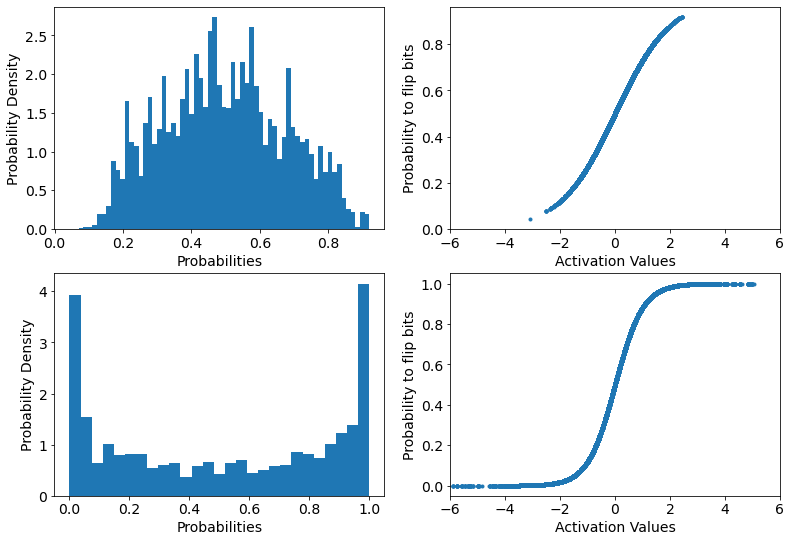

In [4]:
_,ax = plt.subplots(nrows=2, ncols=2, figsize=(13,9))
for i in range(2):
    if i == 0:
        SPINS = False
    else:
        SPINS = True
    v, vmin , GAP = bits(v_original, SPINS=SPINS)
    param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP, original=True)
    w,a,b = param_0['w'],param_0['a'],param_0['b']

    prob = np.array([])
    act = np.array([])
    for x in range(N):
        prob = np.append(prob,activate(v[x],w,b,DE=GAP,prob_info=True))
        act = np.append(act,activate(v[x],w,b,DE=GAP,act_info=True))
    ax[i,0].hist(prob, bins='fd', density=True);
    ax[i,0].set_xlabel("Probabilities")
    ax[i,0].set_ylabel("Probability Density")

    ax[i,1].scatter(act, prob, marker='.')
    ax[i,1].set_xlabel("Activation Values")
    ax[i,1].set_ylabel("Probability to flip bits")
    ax[i,1].set_xlim(-6,6)

As we can see from the pdfs, bits {-1,1} have a bimodal distribution at {0,1}, that implies a strong initial bias in activating either -1 or 1. 
To avoid this behaviour, for bits different from [0,1], we have reshaped the sigma multipling by term in function of the GAP, finding out that the best choice for it is: $$\sigma_{GAP}=2\sqrt{\frac{1}{M+L}}\cdot e^{-\frac{GAP}{2}}=\sigma_0 \cdot e^{-\frac{GAP}{2}} $$

In order to show the goodness of this implementation, we performed it for several values of spins, ranging from {-1,1} to {-5,5}.

#### Check pdfs on bits [0,1],[-1,1],[-2,2],[-3,3],[-4,4],[-5,5]

In [5]:
probabilities = {}
activations = {}
GAPS = np.zeros(6)

for i in range(6):
    probabilities[f'{i}'] = np.array([])
    activations[f'{i}'] = np.array([])
    
    if i == 0:
        v,vmin,GAPS[i] = bits(v_original, SPINS=False)
        param_0 = initialize(M=M, SPINS=False, L=L, GAP=GAPS[i])
    else:
        v,vmin,GAPS[i] = bits(v_original, SPINS=True, spin_value=i)
        param_0 = initialize(M=M, SPINS=True, L=L, GAP=GAPS[i])
    w,a,b = param_0['w'], param_0['a'], param_0['b']
    for x in range(N):
        probabilities[f'{i}'] = np.append(probabilities[f'{i}'], activate(v[x],w,b,DE=GAPS[i],prob_info=True))
        activations[f'{i}'] = np.append(activations[f'{i}'], activate(v[x],w,b,DE=GAPS[i],act_info=True))

#### Violin Plot

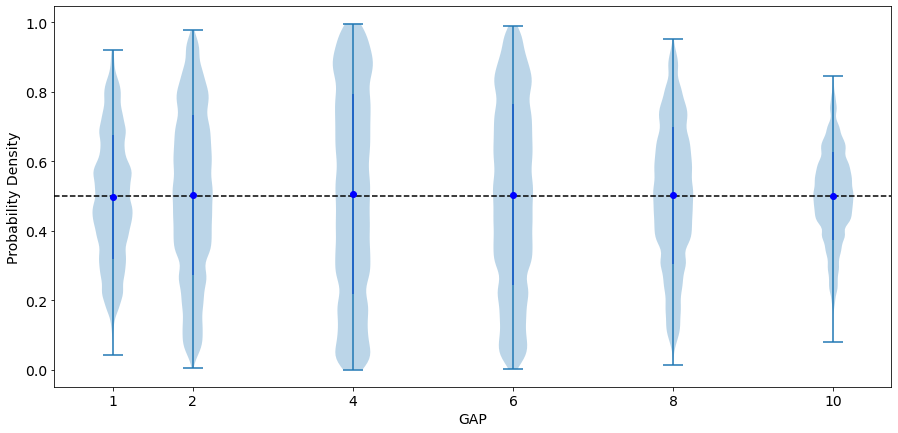

In [6]:
mean_probabilities = []
e = []
for i in range(6):   
    mean_probabilities += [probabilities[f'{i}'].mean()]
    e += [probabilities[f'{i}'].std()]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

ax.errorbar(GAPS, mean_probabilities, e, linestyle='None', marker='o',c="b")

# Create an axes instance
ax.violinplot(probabilities.values(), positions=GAPS)
ax.axhline(y=0.5, color='black', linestyle='--')
ax.set_xlabel("GAP")
ax.set_ylabel("Probability Density")
ax.set_xticks(GAPS)

plt.show()

Above are shown the distributions of the initial probabilities found using $\sigma_{GAP}$ for the cases with spins ranging from {-1,1} to {-5,5}, represented in function of the relative gaps between each max and min spin.

#### Sigmoids for all cases

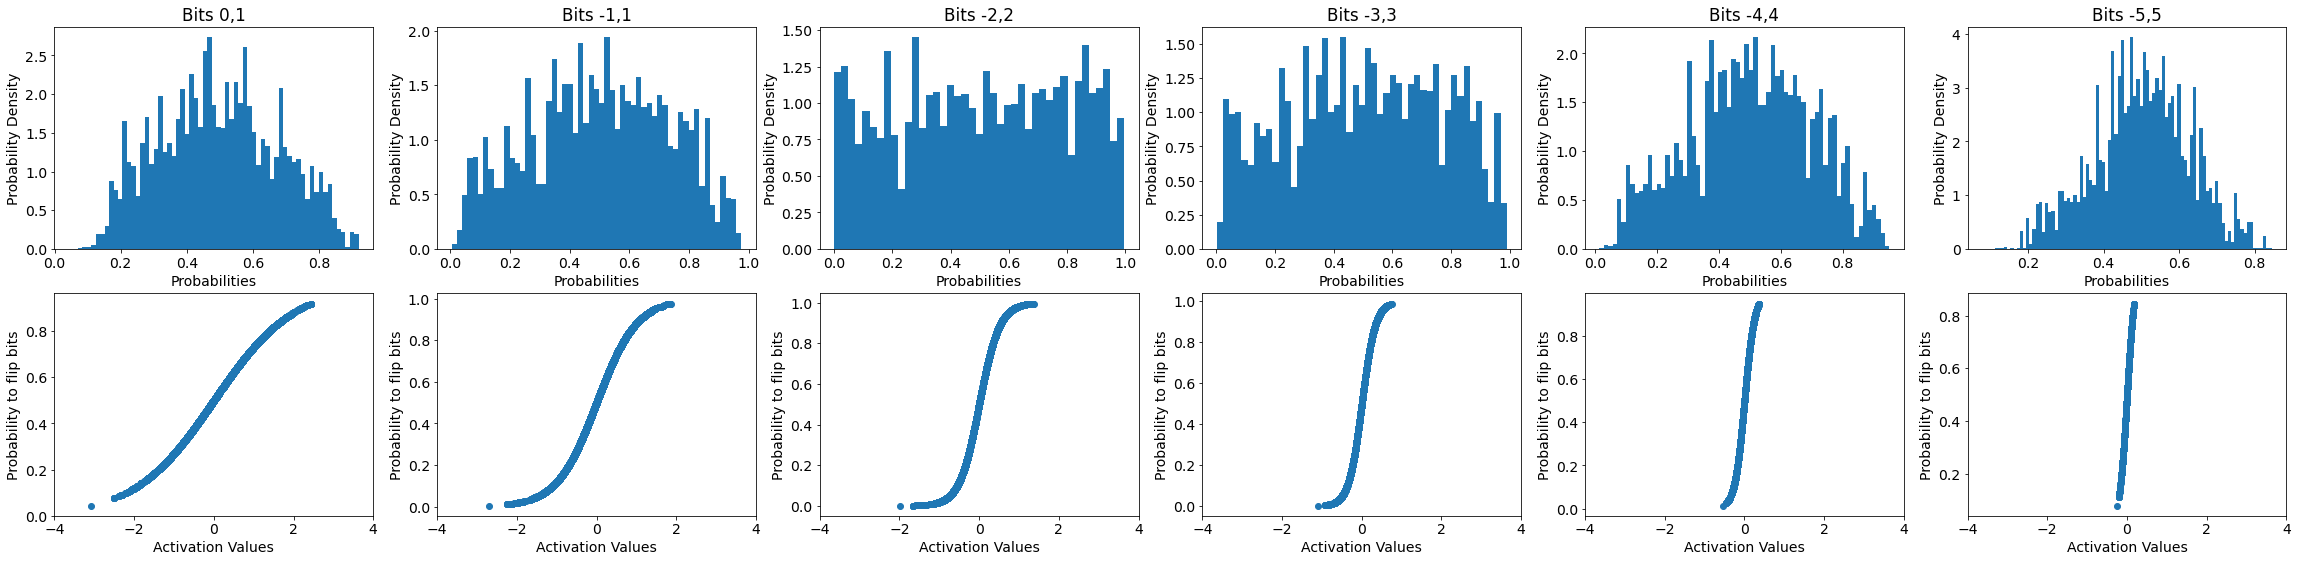

In [7]:
_,ax = plt.subplots(nrows=2, ncols=6, figsize=(40,9))

for i in(range(len(probabilities.values()))):
    ax[0,i].hist(list(probabilities.values())[i], bins='fd', density=True);
    ax[0,i].set_xlabel("Probabilities")
    ax[0,i].set_ylabel("Probability Density")
    if i == 0:
        ax[0,i].set_title("Bits 0,1")
    else:
        ax[0,i].set_title("Bits {},{}".format(-i,i))
    ax[1,i].scatter(list(activations.values())[i], list(probabilities.values())[i])
    ax[1,i].set_xlabel("Activation Values")
    ax[1,i].set_ylabel("Probability to flip bits")
    ax[1,i].set_xlim(-4,4)

## 1. Use bits [0,1] or [-1,1]. Is reading weights easier in one of the two cases?

## 2. Implement an Adam or RMSprop gradient descent algorithm in the RBM notebook.

In [8]:
one_hot = False

In [9]:
# create an Empty DataFrame
# object With column names only
heatmap_df = pd.DataFrame(columns = ['Second Moment Error', 'AAi', 'MSE',"Error",'log-likelihood','Optimizer','CBS'])

# create an Empty ll and energy array
log_like = np.array([])

energy = np.array([])

#### RMSprop

Bits used: [-1,1]


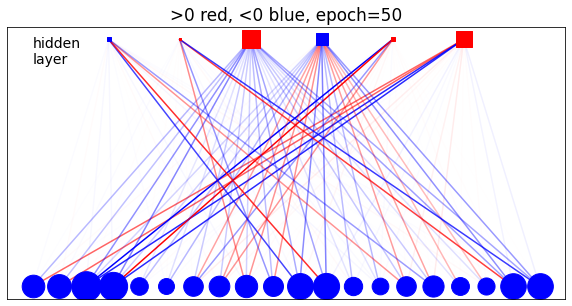

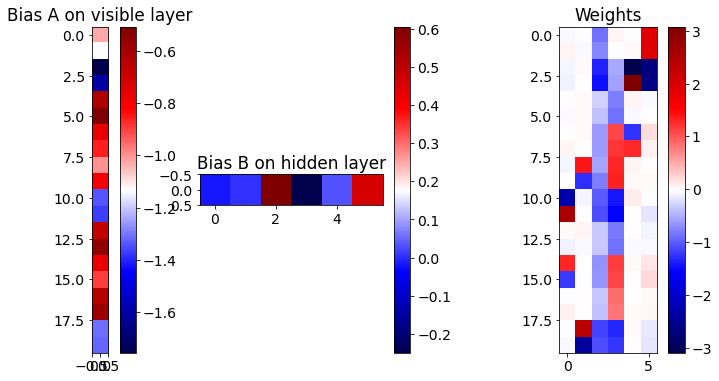

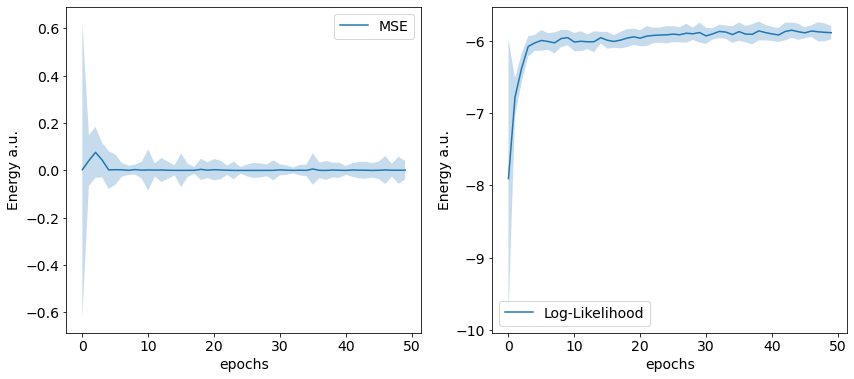

82.78999999999999 % of errors
Bits used: [0,1]


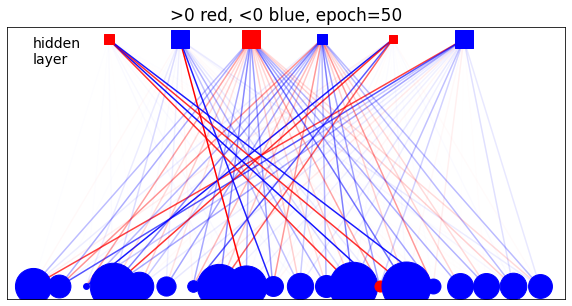

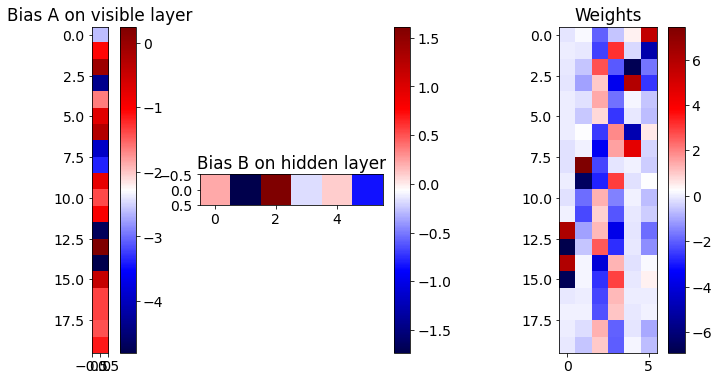

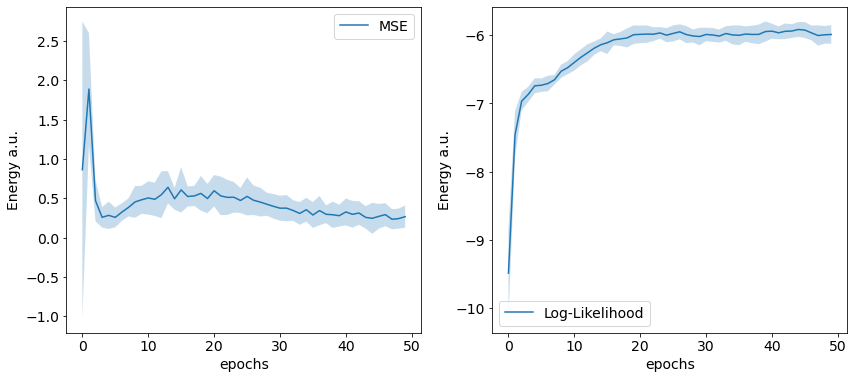

80.75 % of errors


In [10]:
# training
for i in [1,0]:
    print('================================================================')
    print(f'Bits used: [{-i},1]')
    
    SPINS = bool(i)
    
    combinations = comb(M,SPINS)

    v, vmin, GAP = bits(v_original, SPINS=SPINS)

    param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)

    param, E_d, E_m , LL = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='RMSprop', one_hot=one_hot, st_tr=0, l_rate=1, mini=500, graph=False)
    
    
    # output
    w,a,b = param['w'], param['a'], param['b']
    _, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
    _, v15, h15 = output(v, param, one_hot=one_hot, ampl=15) 
    plot_weights_total(w,a,b)
    cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
    
    #ERROR
    err=0
    for l in v15:
        err+=error_detector(l, SPINS)
    
    error = err/N*100
    print(error, "% of errors")
    
    if i ==0:
        MSE = (E_d-E_m)**2
        log_like = np.append(log_like,LL)
        energy = np.append(energy,MSE)
    
    

We have decided to use bits [0,1] since in this case it is easier to read the weights.

In [11]:
SPINS = False

combinations = comb(M,SPINS)

In [12]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'RMSprop','CBS' : one_hot}, 
                ignore_index = True)

In [13]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False


In [14]:
cov_std

0.11150192648731241

#### Vanilla 

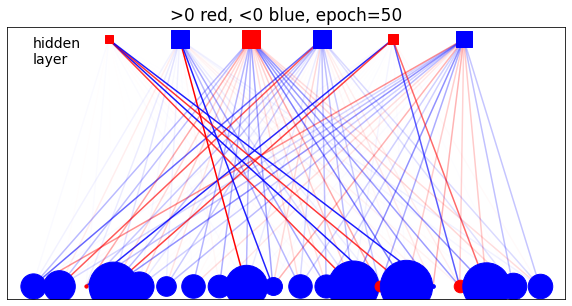

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
5,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
7,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
8,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
9,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,N,P,P,P,N
3,N,P,N,P,N
4,P,P,P,N,P
5,N,P,N,P,N
6,N,P,N,P,N
7,N,P,N,P,N
8,N,P,P,P,N
9,N,P,N,P,N


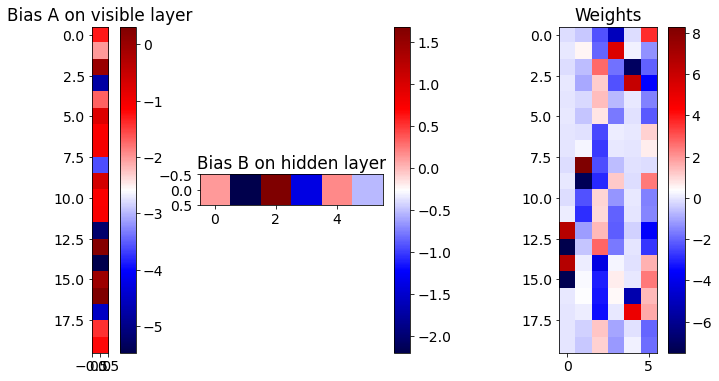

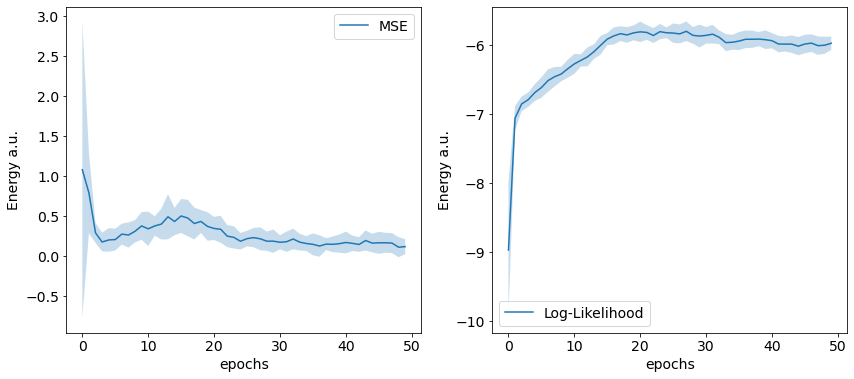

68.54 % of errors


In [15]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)

param, E_d, E_m , LL = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='Vanilla', one_hot=one_hot, st_tr=0, l_rate=1, mini=500, graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)
cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(err/N*100, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))


In [16]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'Vanilla','CBS' : one_hot}, 
                ignore_index = True)

In [17]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False


#### Adam

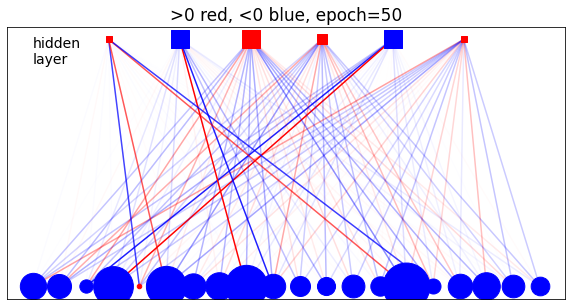

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
2,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
6,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
7,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
8,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,N,P,N,P,N
3,N,P,N,P,N
4,N,P,P,P,N
5,N,P,N,P,N
6,N,P,N,P,N
7,P,N,P,N,P
8,P,N,P,N,P
9,N,P,N,P,N


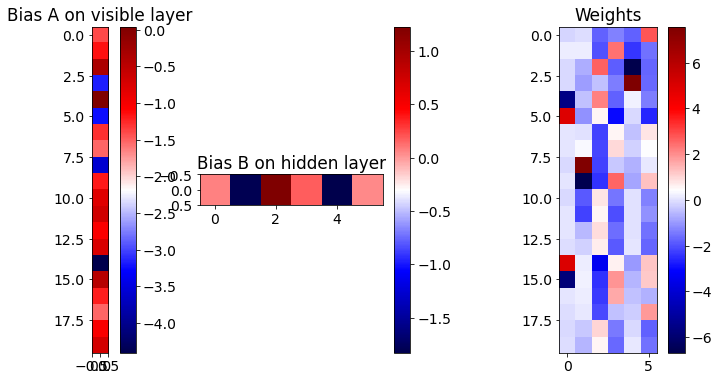

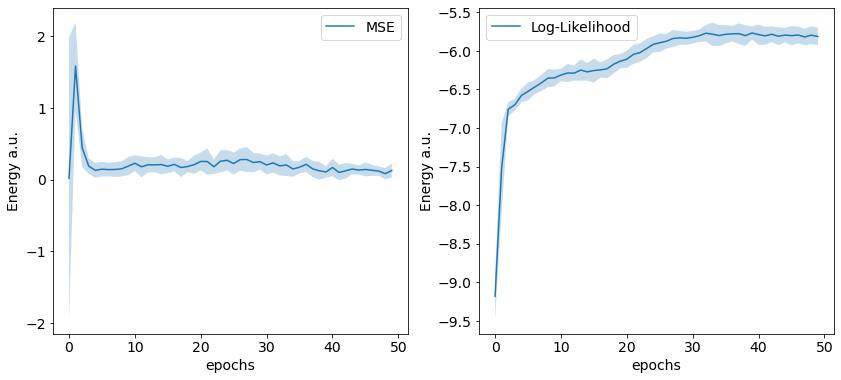

90.36 % of errors


In [18]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)

param, E_d, E_m , LL = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='Adam', one_hot=one_hot, st_tr=0, l_rate=1, mini=500, graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)
cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(err/N*100, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [19]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'Adam','CBS' : one_hot}, 
                ignore_index = True)

In [20]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False


#### Centering Trick

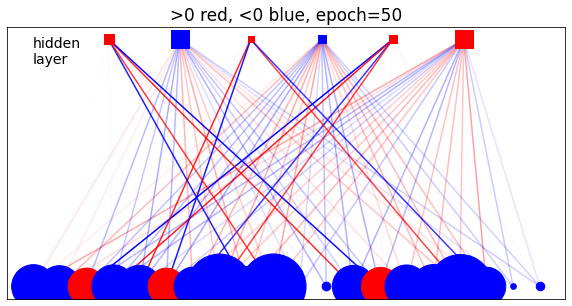

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
5,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
6,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
7,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
9,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


,0,1,2,3,4
0,P,N,P,N,P
1,N,N,N,P,N
2,N,P,P,P,N
3,P,N,P,N,P
4,P,N,P,N,P
5,P,P,P,N,P
6,N,P,N,P,N
7,N,P,N,P,P
8,P,P,N,P,N
9,N,P,N,P,N


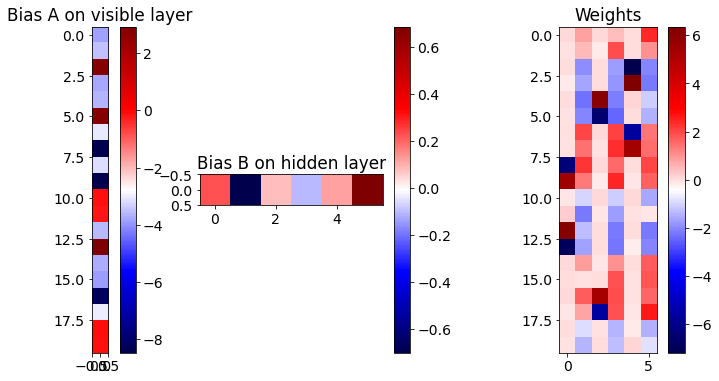

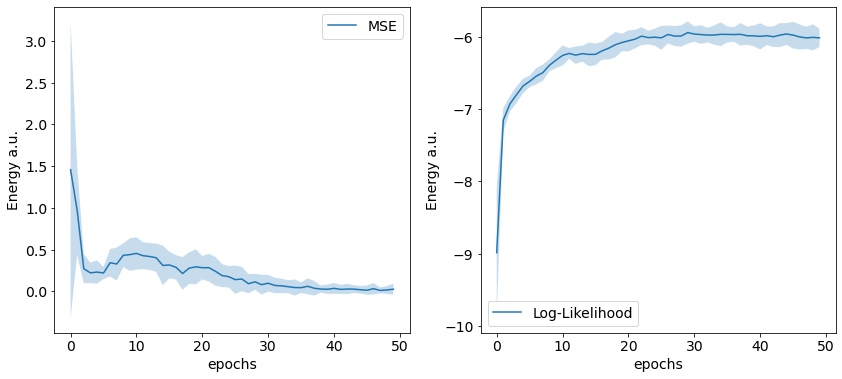

81.27 % of errors


In [21]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)

param, E_d, E_m , LL = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='cent_trick', one_hot=one_hot, st_tr=0, l_rate=1, mini=500, graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)
cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(err/N*100, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [22]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'cent_trick','CBS' : one_hot}, 
                ignore_index = True)

In [23]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False
3,0.17638+-0.06959,0.1643+-0.0117,0.025+-0.067,81.27,-6.013+-0.127,cent_trick,False


## 3. Increase the number of contrastive divergence steps.

#### RMSprop

CD-1


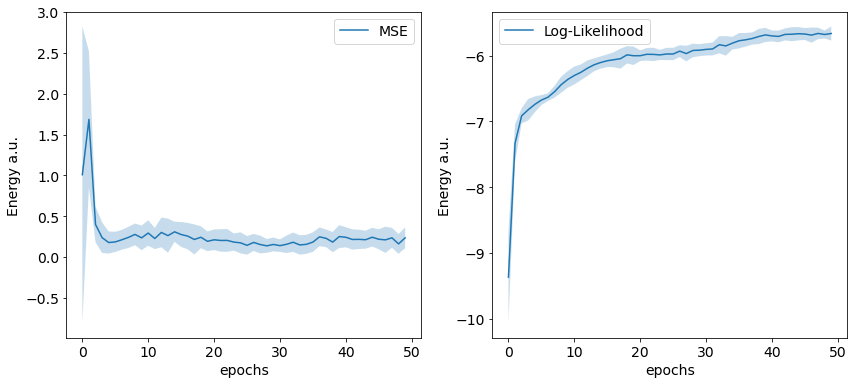

83.75 % of errors
CD-2


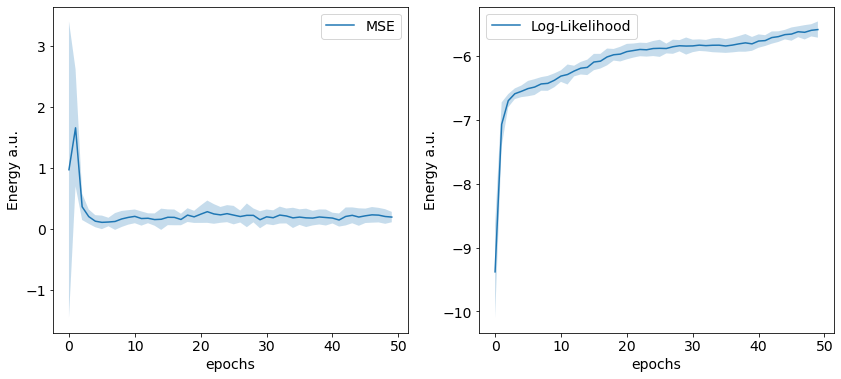

89.36 % of errors
CD-3


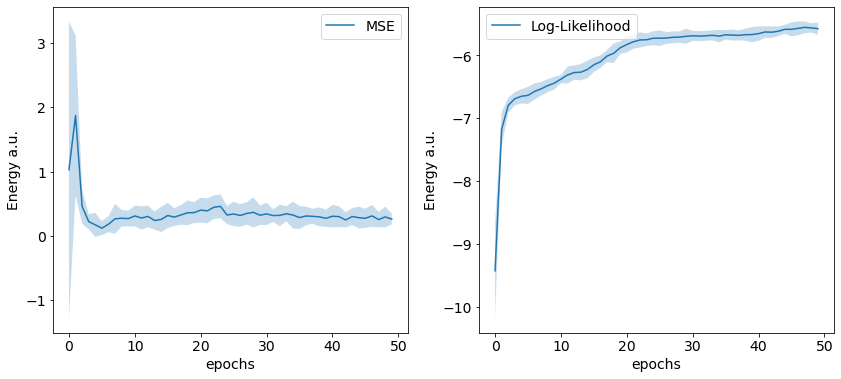

86.94 % of errors
CD-4


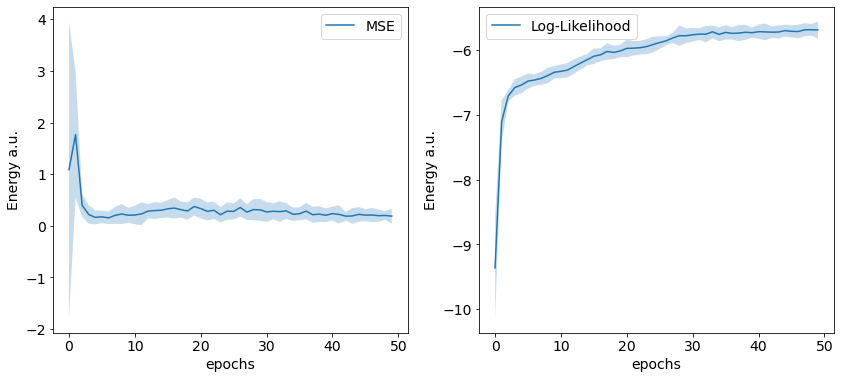

75.2 % of errors


In [24]:
# create an Empty DataFrame
# object With column names only
heatmap_df_cd = pd.DataFrame(columns = ['Second Moment Error', 'AAi', 'MSE',"Error",'log-likelihood','Optimizer','CBS', 'CD Steps'])


one_hot = False

for i in range(1,5):
    # training
    v, vmin, GAP = bits(v_original, SPINS=SPINS)
    param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
    #mettere nepoch 100
    print('================================================================')
    print(f'CD-{i}')
    param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='RMSprop', one_hot=one_hot, n_cd_step = i, st_tr=0, graph=False, final_graph=False)

    # output
    w,a,b = param['w'], param['a'], param['b']
    _, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
    _, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
    cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
    #ERROR
    err=0
    for l in v15:
        err+=error_detector(l, SPINS)

    error = err/N*100
    print(error, "% of errors")
    
    #### Append the indicators to the dataframe
    heatmap_df_cd = heatmap_df_cd.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'RMSprop','CBS' : one_hot,'CD Steps' : i}, 
                ignore_index = True)


each of N=10000 data has L=20 digits


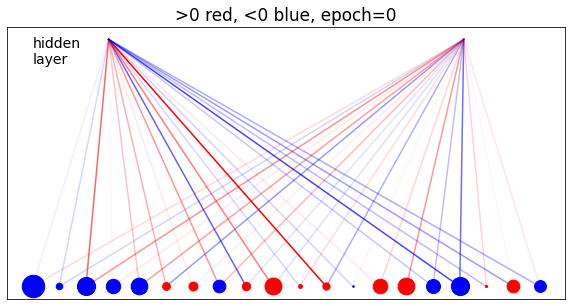

In [25]:
CASE=1

if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)

v_original = v.copy()

# number of samples
N = len(v)
# number of visible neurons
L = len(v[1])
#number of hidden variables
if CASE==0: M = 3
if CASE==1: M = 2 

print(f'each of N={N} data has L={L} digits')

#graphs initialization 
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

v, vmin , GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP, original=True)
w,a,b = param_0['w'],param_0['a'],param_0['b']
    
plotgraph(w,a,b)

combinations = comb(M,SPINS)

CD-1


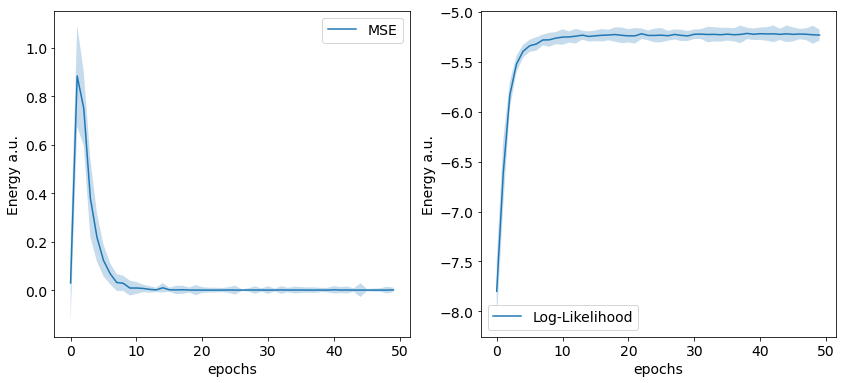

0.0 % of errors
CD-2


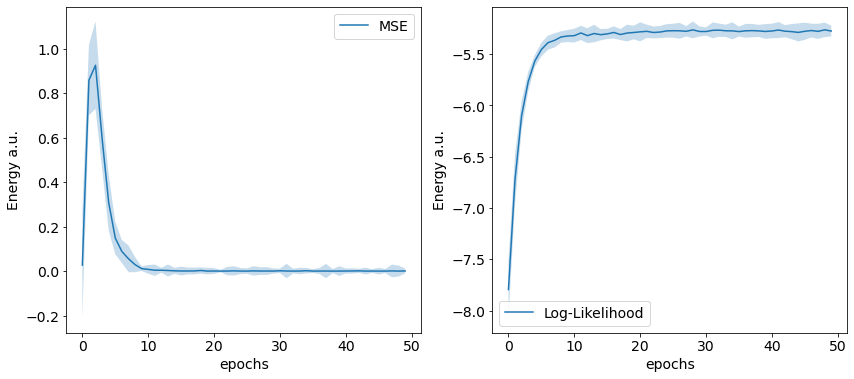

0.0 % of errors
CD-3


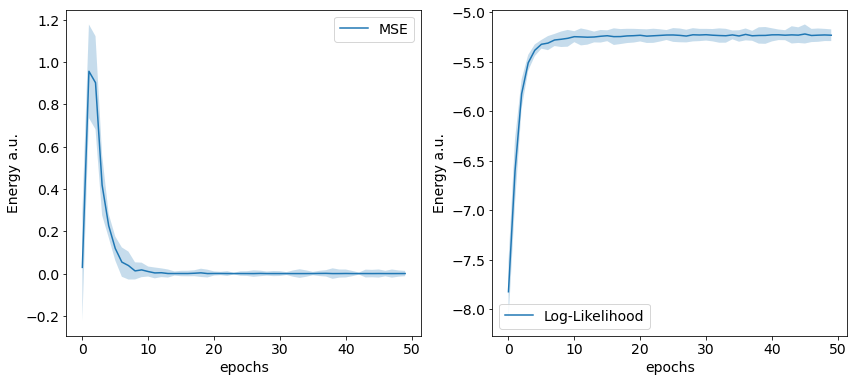

0.0 % of errors
CD-4


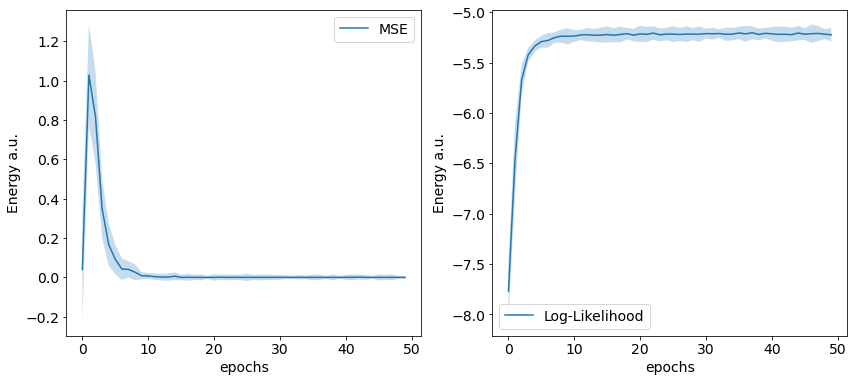

0.0 % of errors


In [26]:
one_hot = True

for i in range(1,5):
    # training
    v, vmin, GAP = bits(v_original, SPINS=SPINS)
    param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
    #mettere nepoch 100
    print('================================================================')
    print(f'CD-{i}')
    param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='RMSprop', one_hot=one_hot, n_cd_step = i, st_tr=0, graph=False, final_graph=False)

    # output
    w,a,b = param['w'], param['a'], param['b']
    _, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
    _, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
    cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)
    #ERROR
    err=0
    for l in v15:
        err+=error_detector(l, SPINS)

    error = err/N*100
    print(error, "% of errors")
    
    #### Append the indicators to the dataframe
    heatmap_df_cd = heatmap_df_cd.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                        'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'RMSprop','CBS' : one_hot,'CD Steps' : i}, 
                ignore_index = True)

In [27]:
heatmap_df_cd

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS,CD Steps
0,0.18658+-0.06063,0.1999+-0.0087,0.236+-0.127,83.75,-5.666+-0.107,RMSprop,False,1
1,0.22051+-0.09053,0.2009+-0.0059,0.194+-0.086,89.36,-5.579+-0.127,RMSprop,False,2
2,0.20824+-0.11501,0.1887+-0.0105,0.259+-0.085,86.94,-5.573+-0.097,RMSprop,False,3
3,0.1734+-0.05701,0.1884+-0.0086,0.189+-0.147,75.20,-5.69+-0.131,RMSprop,False,4
4,0.24044+-0.14294,0.0003+-0.0003,0.001+-0.009,0.00,-5.233+-0.055,RMSprop,True,1
5,0.17626+-0.11471,0.0001+-0.0001,0.001+-0.011,0.00,-5.274+-0.053,RMSprop,True,2
6,0.186+-0.10356,0.0003+-0.0002,0.0+-0.013,0.00,-5.232+-0.059,RMSprop,True,3
7,0.27847+-0.22899,0.0001+-0.0001,0.0+-0.007,0.00,-5.225+-0.068,RMSprop,True,4


In [28]:
#M = len(b)

# fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# # reshape flights dataset in proper format to create seaborn heatmap
# pivot_heatmap_df_cd = heatmap_df_cd.pivot('CBS','CD Steps','Second Moment Error') 
# sns.heatmap(pivot_heatmap_df_cd, ax=axes[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[0].set_title('Second Moment Error')

# # reshape flights dataset in proper format to create seaborn heatmap
# pivot_heatmap_df_cd = heatmap_df_cd.pivot('CBS','CD Steps','AAi') 
# sns.heatmap(pivot_heatmap_df_cd, ax=axes[1], annot=True, linewidth=.5,cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[1].set_title("AAi")

# fig2, axes2 = plt.subplots(1, 2, figsize=(16, 4))

# # reshape flights dataset in proper format to create seaborn heatmap
# pivot_heatmap_df_cd = heatmap_df_cd.pivot('CBS','CD Steps','Error') 
# sns.heatmap(pivot_heatmap_df_cd, ax=axes2[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[0].set_title("Error")

# # reshape flights dataset in proper format to create seaborn heatmap
# pivot_heatmap_df_cd = heatmap_df_cd.pivot('CBS','CD Steps','MSE') 
# sns.heatmap(pivot_heatmap_df_cd, ax=axes2[1], annot=True, linewidth=.5 ,cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[1].set_title("MSE")

#M = len(b)

# fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df_cd.pivot('CBS','CD Steps','Second Moment Error')
pivot_heatmap_df.to_html('heatmap_df_cd_Second Moment Error.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[0].set_title('Second Moment Error')

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df_cd.pivot('CBS','CD Steps','AAi') 
pivot_heatmap_df.to_html('heatmap_df_cd_AAi.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[1], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[1].set_title("AAi")

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df_cd.pivot('CBS','CD Steps','MSE') 
pivot_heatmap_df.to_html('heatmap_df_cd_MSE.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[2], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[2].set_title("MSE")

# fig2, axes2 = plt.subplots(1, 2, figsize=(14, 4))

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df_cd.pivot('CBS','CD Steps','Error') 
pivot_heatmap_df.to_html('heatmap_df_cd_Error.html')
# sns.heatmap(pivot_heatmap_df, ax=axes2[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[0].set_title("Error")

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df_cd.pivot('CBS','CD Steps','log-likelihood') 
pivot_heatmap_df.to_html('heatmap_df_cd_log-likelihood.html')
# sns.heatmap(pivot_heatmap_df, ax=axes2[1], annot=True, linewidth=.5 ,cbar=False,fmt=".3f",cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[1].set_title("log-likelihood")

## 4. Implement a backward step of contrastive divergence that preserves the one-hot encoding structure, thus generating one of $A$ states in a block rather than one of $2^{A}$ possible states. One randomly picks a block of $A$ bits with probability proportional to the Boltzmann weight of its one-hot encoding, given the state of hidden units, the weights, and the local biases in that block.

In [29]:
one_hot = True

In [30]:
CASE=1

if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
    
fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)

v_original = v.copy()

# number of samples
N = len(v)
# number of visible neurons
L = len(v[1])
#number of hidden variables
if CASE==0: M = 3
if CASE==1: M = 2 #da commentare

print(f'each of N={N} data has L={L} digits')

#graphs initialization 
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

combinations = comb(M,SPINS)

each of N=10000 data has L=20 digits


#### Vanilla

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
4,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
7,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
8,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
9,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1


,0,1,2,3,4
0,P,N,P,P,P
1,P,N,P,N,N
2,N,P,N,P,N
3,P,N,P,N,P
4,N,P,N,P,P
5,N,P,N,P,N
6,N,P,N,P,N
7,P,P,N,N,P
8,N,P,N,P,N
9,N,P,N,P,N


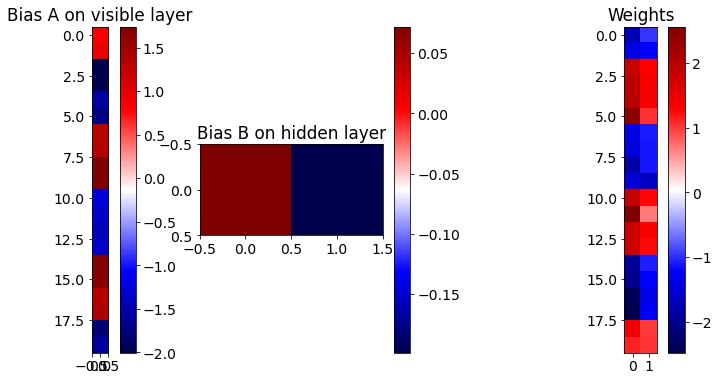

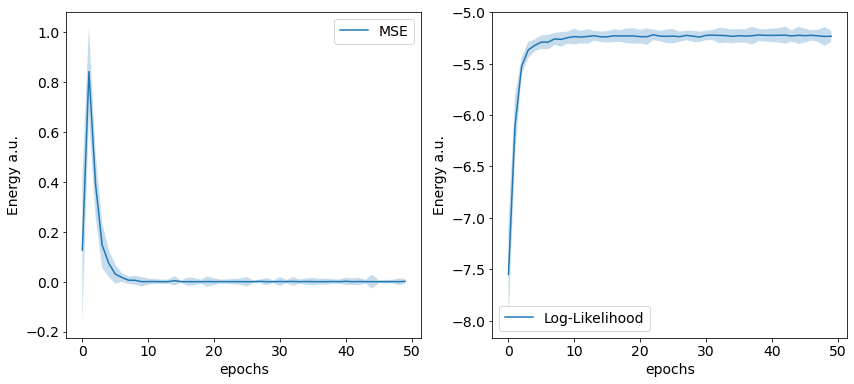

0.0 % of errors


In [31]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='Vanilla', one_hot=one_hot, n_cd_step = 1, st_tr=0, graph=False, final_graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)
cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)

#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(error, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [32]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                    'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'Vanilla','CBS' : one_hot}, 
            ignore_index = True)

In [33]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False
3,0.17638+-0.06959,0.1643+-0.0117,0.025+-0.067,81.27,-6.013+-0.127,cent_trick,False
4,0.25478+-0.14772,0.0003+-0.0003,0.001+-0.01,0.00,-5.233+-0.054,Vanilla,True


#### RMSprop

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
5,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0
6,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
7,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
8,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
9,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0


,0,1,2,3,4
0,P,N,P,N,P
1,N,P,N,P,N
2,N,P,N,P,N
3,N,P,N,P,N
4,N,N,P,N,P
5,P,N,P,N,P
6,N,P,N,P,N
7,N,P,N,P,N
8,P,N,P,N,P
9,P,N,P,N,P


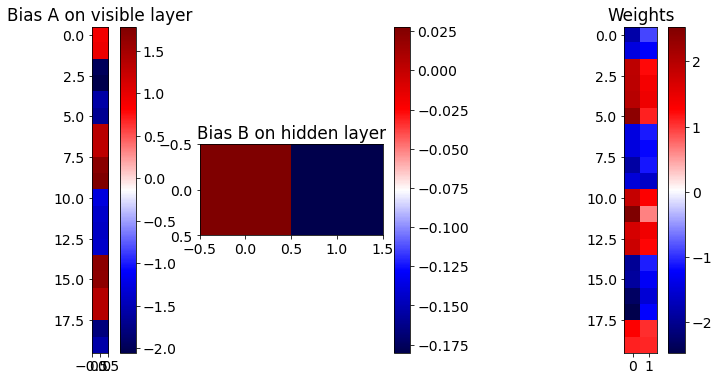

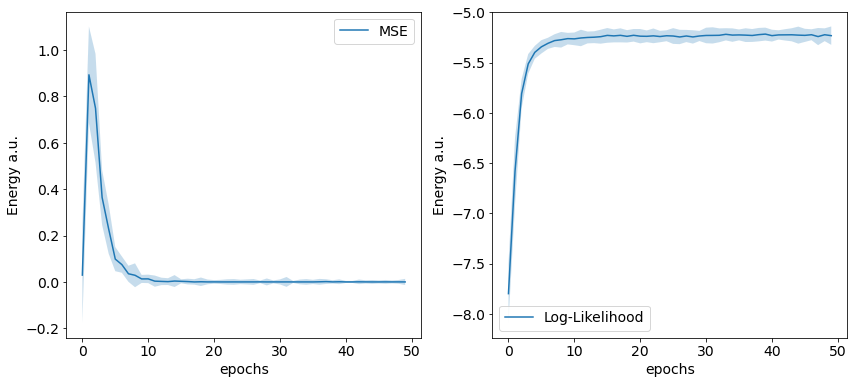

0.0 % of errors


In [34]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='RMSprop', one_hot=one_hot, n_cd_step = 1, st_tr=0, graph=False, final_graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)
cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)

#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(error, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [35]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                    'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'RMSprop','CBS' : one_hot}, 
            ignore_index = True)

In [36]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False
3,0.17638+-0.06959,0.1643+-0.0117,0.025+-0.067,81.27,-6.013+-0.127,cent_trick,False
4,0.25478+-0.14772,0.0003+-0.0003,0.001+-0.01,0.00,-5.233+-0.054,Vanilla,True
5,0.23989+-0.12788,0.0003+-0.0002,0.0+-0.013,0.00,-5.231+-0.092,RMSprop,True


#### Adam

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
2,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
5,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
6,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
7,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
8,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0
9,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0


,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,N,P,P,P,N
3,N,P,N,P,N
4,P,N,P,N,P
5,N,P,N,P,N
6,N,P,N,P,N
7,P,N,P,N,P
8,P,N,P,P,P
9,P,N,P,N,P


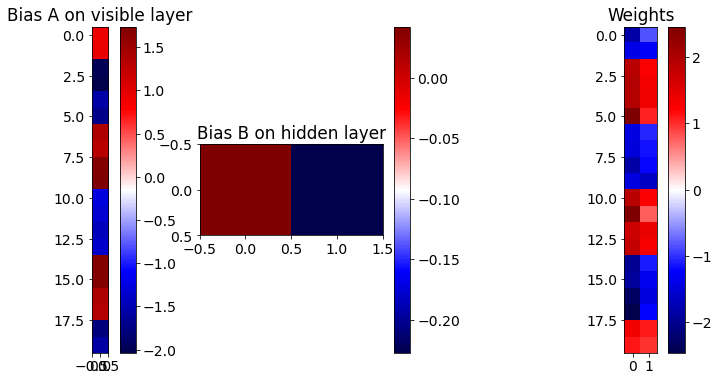

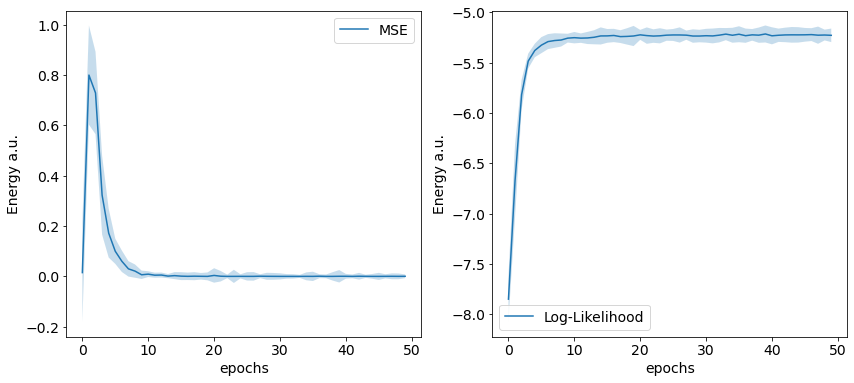

0.0 % of errors


In [37]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='Adam', one_hot=one_hot, n_cd_step = 1, st_tr=0, graph=False, final_graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)

cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)

#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(error, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [38]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                    'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'Adam','CBS' : one_hot}, 
            ignore_index = True)

In [39]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False
3,0.17638+-0.06959,0.1643+-0.0117,0.025+-0.067,81.27,-6.013+-0.127,cent_trick,False
4,0.25478+-0.14772,0.0003+-0.0003,0.001+-0.01,0.00,-5.233+-0.054,Vanilla,True
5,0.23989+-0.12788,0.0003+-0.0002,0.0+-0.013,0.00,-5.231+-0.092,RMSprop,True
6,0.19018+-0.1064,0.0001+-0.0001,0.0+-0.007,0.00,-5.228+-0.067,Adam,True


#### Centering Trick

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
5,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
6,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
7,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
8,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
9,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0


,0,1,2,3,4
0,N,P,N,N,N
1,N,P,N,P,N
2,N,P,N,P,N
3,N,P,P,P,P
4,N,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,P
7,P,N,P,N,P
8,N,P,N,P,N
9,N,N,P,N,P


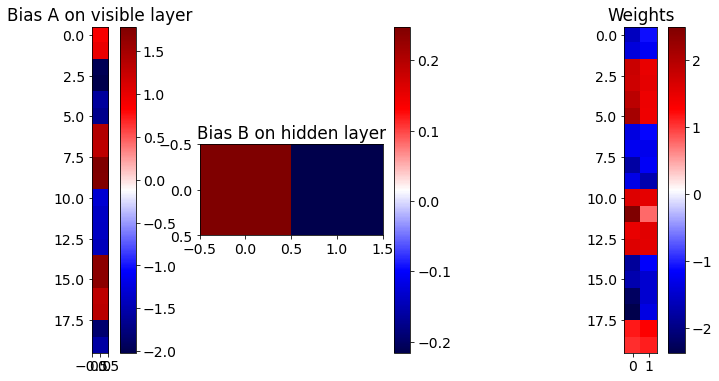

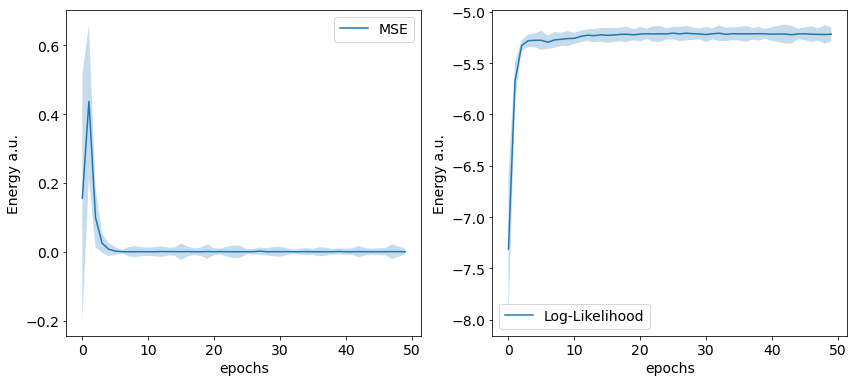

0.0 % of errors


In [40]:
# training
v, vmin, GAP = bits(v_original, SPINS=SPINS)
param_0 = initialize(M=M, SPINS=SPINS, L=L, GAP=GAP)
param, E_d, E_m, LL  = rbm_training(v, param_0, M=M, GAP=GAP, optimizer='cent_trick', one_hot=one_hot, n_cd_step = 1, st_tr=0, graph=False, final_graph=False)

# output
w,a,b = param['w'], param['a'], param['b']
_, v1, h1 = output(v, param, one_hot=one_hot, ampl=1)
_, v15, h15 = output(v, param, one_hot=one_hot, ampl=15)
plot_tables(v, v15, vmin, N1=10)
plot_weights_total(w,a,b)

cov,cov_std,eps,eps_std,E_d_m_diff,E_d_m_diff_std,ll,ll_std = PlotIndic(E_d,E_m,LL,v_original,v1,200)

#ERROR
err=0
for l in v15:
    err+=error_detector(l, SPINS)
error = err/N*100
print(error, "% of errors")

# We save the LL and MSE for plotting
MSE = (E_d-E_m)**2
log_like = np.vstack((log_like,LL))
energy = np.vstack((energy,MSE))

In [41]:
#### Append the indicators to the dataframe
heatmap_df = heatmap_df.append({'Second Moment Error' : f'{round(cov,5)}+-{round(cov_std,5)}', 'AAi' : f'{round(eps,4)}+-{round(eps_std,4)}', 'MSE' : f'{round(E_d_m_diff,3)}+-{round(E_d_m_diff_std,3)}', "Error" : error,
                    'log-likelihood' : f'{round(ll,3)}+-{round(ll_std,3)}','Optimizer' : 'cent_trick','CBS' : one_hot}, 
            ignore_index = True)

In [42]:
heatmap_df

,Second Moment Error,AAi,MSE,Error,log-likelihood,Optimizer,CBS
0,0.17565+-0.1115,0.17+-0.0099,0.266+-0.141,80.75,-5.986+-0.136,RMSprop,False
1,0.23592+-0.13799,0.1641+-0.0084,0.12+-0.094,68.54,-5.971+-0.096,Vanilla,False
2,0.1949+-0.08935,0.2018+-0.0106,0.127+-0.097,90.36,-5.812+-0.112,Adam,False
3,0.17638+-0.06959,0.1643+-0.0117,0.025+-0.067,81.27,-6.013+-0.127,cent_trick,False
4,0.25478+-0.14772,0.0003+-0.0003,0.001+-0.01,0.00,-5.233+-0.054,Vanilla,True
5,0.23989+-0.12788,0.0003+-0.0002,0.0+-0.013,0.00,-5.231+-0.092,RMSprop,True
6,0.19018+-0.1064,0.0001+-0.0001,0.0+-0.007,0.00,-5.228+-0.067,Adam,True
7,0.23087+-0.07511,0.0002+-0.0002,0.0+-0.008,0.00,-5.219+-0.068,cent_trick,True


## Indicator Heatmaps

In [43]:
#M = len(b)

# fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df.pivot('CBS','Optimizer','Second Moment Error')
pivot_heatmap_df.to_html('pivot_heatmap_df_Second Moment Error.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[0].set_title('Second Moment Error')

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df.pivot('CBS','Optimizer','AAi') 
pivot_heatmap_df.to_html('pivot_heatmap_df_AAi.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[1], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[1].set_title("AAi")

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df.pivot('CBS','Optimizer','MSE') 
pivot_heatmap_df.to_html('pivot_heatmap_df_MSE.html')
# sns.heatmap(pivot_heatmap_df, ax=axes[2], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes[2].set_title("MSE")

# fig2, axes2 = plt.subplots(1, 2, figsize=(14, 4))

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df.pivot('CBS','Optimizer','Error') 
pivot_heatmap_df.to_html('pivot_heatmap_df_Error.html')
# sns.heatmap(pivot_heatmap_df, ax=axes2[0], annot=True, linewidth=.5, cbar=False,cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[0].set_title("Error")

# reshape flights dataset in proper format to create seaborn heatmap
pivot_heatmap_df = heatmap_df.pivot('CBS','Optimizer','log-likelihood') 
pivot_heatmap_df.to_html('pivot_heatmap_df_log-likelihood.html')
# sns.heatmap(pivot_heatmap_df, ax=axes2[1], annot=True, linewidth=.5 ,cbar=False,fmt=".3f",cmap=sns.cubehelix_palette(as_cmap=True))
# axes2[1].set_title("log-likelihood")

## Plot log-likelihoods and MSE

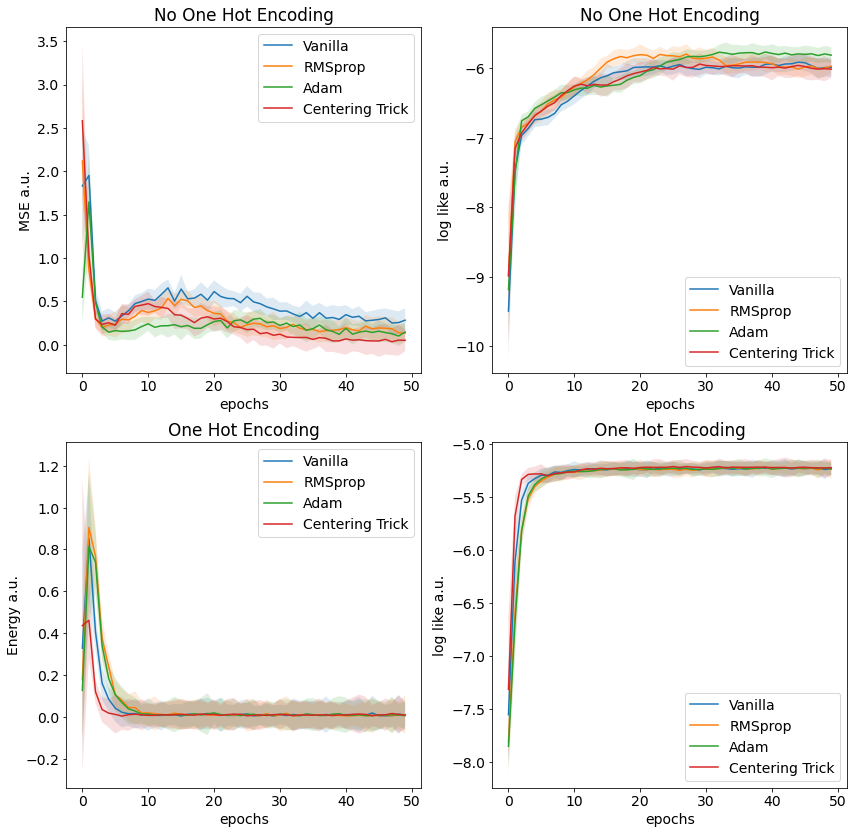

In [44]:
log_mse_plot()

## Optional

#### 5. Plot the weights wiμ of each hidden unit μ in an A×G table (as in the example on the right), with a color map preserving the rule that red means positive and blue means negative weight.

#### Already done above.

5. b)
Implement the "centering trick" described in the following pages, taken from Matteo Bortoletto's
master thesis (note that different symbols for biases: a→b, b→c).

#### Already done above.

6.
Compute the log-likelihood L as a function of the epoch, or try one of the other quality indicators
proposed in the paper by Decelle et al (drive), see especially the supplementary pdf. To compute the
partition function (the hardest part in evaluating L), in our case one needs AG
*2M~105
 Boltzmann
factors, which is doable.

#### Already done above.